<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment3/blob/main/Ques_5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.optim as optim
from tqdm import tqdm

import shutil
import pandas as pd

from collections import Counter

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Source folder in Google Drive
src_folder = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons'

# Destination in Colab's local storage
dst_folder = '/content/hindi_data'

# Copy the entire folder
shutil.copytree(src_folder, dst_folder)

'/content/hindi_data'

In [ ]:
# Load the data
df_train = pd.read_csv("hindi_data/hi.translit.sampled.train.tsv", sep="\t", header=None, names=["target", "input", "num"])
# Drop rows with NaNs (if any)
df_train = df_train.dropna()

df_val = pd.read_csv("hindi_data/hi.translit.sampled.dev.tsv", sep="\t", header=None, names=["target", "input", "num"])
df_val = df_val.dropna()

df_test = pd.read_csv("hindi_data/hi.translit.sampled.test.tsv", sep="\t", header=None, names=["target", "input", "num"])
df_test = df_val.dropna()

In [ ]:
# Special tokens
PAD_token = "<pad>"
SOS_token = "<sos>"  # start of sequence
EOS_token = "<eos>"  # end of sequence

def build_vocab(sequences):
    vocab = set(char for seq in sequences for char in seq)
    vocab = [PAD_token, SOS_token, EOS_token] + sorted(vocab)
    char2idx = {c: i for i, c in enumerate(vocab)}
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char

input_char2idx, input_idx2char = build_vocab(df_train["input"])
target_char2idx, target_idx2char = build_vocab(df_train["target"])

print(f"Input vocab size: {len(input_char2idx)}")
print(f"Target vocab size: {len(target_char2idx)}")

Input vocab size: 29
Target vocab size: 66


In [ ]:
def encode_sequence(seq, char2idx, add_sos_eos=True):
    tokens = [char2idx[c] for c in seq]
    if add_sos_eos:
        tokens = [char2idx[SOS_token]] + tokens + [char2idx[EOS_token]]
    return tokens

input_sequences = [encode_sequence(seq, input_char2idx) for seq in df_train["input"]]
target_sequences = [encode_sequence(seq, target_char2idx) for seq in df_train["target"]]

input_val = [encode_sequence(seq, input_char2idx) for seq in df_val["input"]]
target_val = [encode_sequence(seq, target_char2idx) for seq in df_val["target"]]


input_test = [encode_sequence(seq, input_char2idx) for seq in df_test["input"]]
target_test = [encode_sequence(seq, target_char2idx) for seq in df_test["target"]]

In [ ]:
class TransliterationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=input_char2idx[PAD_token])
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=target_char2idx[PAD_token])
    return inputs_padded, targets_padded

train_dataset = TransliterationDataset(input_sequences, target_sequences)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

val_dataset = TransliterationDataset(input_val, target_val)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

test_dataset = TransliterationDataset(input_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hidden_dim, cell_type='gru', dropout =0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[cell_type]
        self.rnn = rnn_cls(emb_dim, enc_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1]
        hidden = hidden.unsqueeze(1)
        hidden = hidden.repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention, cell_type='gru', dropout=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = attention
        rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[cell_type]
        self.rnn = rnn_cls(enc_hidden_dim + emb_dim, dec_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        attn_weights = self.attention(hidden if not isinstance(hidden, tuple) else hidden[0], encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        pred = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return pred, hidden, attn_weights


In [ ]:
def train(model, dataloader, encoder, decoder, enc_optimizer, dec_optimizer, criterion, device, tgt_pad_idx):
    encoder.train()
    decoder.train()
    epoch_loss = 0

    for src, tgt in tqdm(dataloader):
        src, tgt = src.to(device), tgt.to(device)
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        encoder_outputs, hidden = encoder(src)
        input = tgt[:, 0]
        loss = 0

        for t in range(1, tgt.size(1)):
            output, hidden, _ = decoder(input, hidden, encoder_outputs)
            loss += criterion(output, tgt[:, t])
            input = tgt[:, t]  # Teacher forcing

        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        epoch_loss += loss.item() / (tgt.size(1) - 1)

    return epoch_loss / len(dataloader)


In [ ]:
def evaluate(model, dataloader, encoder, decoder, tgt_idx2char, tgt_char2idx, device, max_len=30):
    encoder.eval()
    decoder.eval()

    all_predictions = []
    all_targets = []
    total_chars = 0
    correct_chars = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            batch_size = src.size(0)
            encoder_outputs, hidden = encoder(src)

            input = torch.tensor([tgt_char2idx['<sos>']] * batch_size).to(device)
            outputs = []


            for _ in range(max_len):
                output, hidden, _ = decoder(input, hidden, encoder_outputs)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input = top1

            outputs = torch.cat(outputs, dim=1)

            # Convert predictions and targets to strings for comparison
            for pred_seq, tgt_seq in zip(outputs, tgt[:, 1:]):  # Skip <sos> in tgt
                pred_str = []
                tgt_str = []
                for p, t in zip(pred_seq, tgt_seq):
                    p_ch = tgt_idx2char.get(p.item(), '')
                    t_ch = tgt_idx2char.get(t.item(), '')
                    if t_ch == '<eos>':
                        break
                    pred_str.append(p_ch)
                    tgt_str.append(t_ch)

                all_predictions.append("".join(pred_str))
                all_targets.append("".join(tgt_str))

                # Accuracy count
                match_len = min(len(pred_str), len(tgt_str))
                for i in range(match_len):
                    if pred_str[i] == tgt_str[i]:
                        correct_chars += 1
                total_chars += len(tgt_str)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0.0
    return accuracy, all_predictions, all_targets


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
INPUT_DIM = len(input_char2idx)
OUTPUT_DIM = len(target_char2idx)
EMB_DIM = 128
HID_DIM = 256

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)
attention = BahdanauAttention(HID_DIM, HID_DIM).to(device)
decoder = DecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, attention).to(device)

enc_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=target_char2idx['<pad>'])

for epoch in range(15):
    loss = train(None, train_dataloader, encoder, decoder, enc_optimizer, dec_optimizer, criterion, device, target_char2idx['<pad>'])
    accuracy, _ , _ = evaluate(None, val_dataloader, encoder, decoder, target_idx2char, target_char2idx, device, max_len=30)

    val_accuracy = accuracy*100

    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f} | val_accuracy: {accuracy:.2f}%")


100%|██████████| 346/346 [00:13<00:00, 26.30it/s]


Epoch 1 | Train Loss: 2.6025 | Val Acc: 10.02%


100%|██████████| 346/346 [00:13<00:00, 26.38it/s]


Epoch 2 | Train Loss: 1.9396 | Val Acc: 16.91%


100%|██████████| 346/346 [00:13<00:00, 26.42it/s]


Epoch 3 | Train Loss: 1.5196 | Val Acc: 25.99%


100%|██████████| 346/346 [00:13<00:00, 26.13it/s]


Epoch 4 | Train Loss: 1.1441 | Val Acc: 39.23%


100%|██████████| 346/346 [00:13<00:00, 26.13it/s]


Epoch 5 | Train Loss: 0.8456 | Val Acc: 49.50%


100%|██████████| 346/346 [00:14<00:00, 24.59it/s]


Epoch 6 | Train Loss: 0.6951 | Val Acc: 54.35%


100%|██████████| 346/346 [00:13<00:00, 25.71it/s]


Epoch 7 | Train Loss: 0.5942 | Val Acc: 55.21%


100%|██████████| 346/346 [00:13<00:00, 26.33it/s]


Epoch 8 | Train Loss: 0.5423 | Val Acc: 57.38%


100%|██████████| 346/346 [00:13<00:00, 25.18it/s]


Epoch 9 | Train Loss: 0.4969 | Val Acc: 59.28%


100%|██████████| 346/346 [00:13<00:00, 26.50it/s]


Epoch 10 | Train Loss: 0.4584 | Val Acc: 60.93%


100%|██████████| 346/346 [00:13<00:00, 26.15it/s]


Epoch 11 | Train Loss: 0.4302 | Val Acc: 61.60%


100%|██████████| 346/346 [00:13<00:00, 25.86it/s]


Epoch 12 | Train Loss: 0.4077 | Val Acc: 62.57%


100%|██████████| 346/346 [00:14<00:00, 24.61it/s]


Epoch 13 | Train Loss: 0.3850 | Val Acc: 63.01%


100%|██████████| 346/346 [00:14<00:00, 24.42it/s]


Epoch 14 | Train Loss: 0.3712 | Val Acc: 63.82%


100%|██████████| 346/346 [00:13<00:00, 25.12it/s]


Epoch 15 | Train Loss: 0.3560 | Val Acc: 64.47%


In [ ]:
import wandb

sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [64, 128]
        },
        'hidden_layer_size': {
            'values': [256, 512]
        },
        'cell_type': {
            'values': ['lstm', 'gru']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
         'learning_rate': {
            'values': [0.001, 0.0001]
        },
    }
}
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
sweep_id = wandb.sweep(sweep = sweep_config, entity="arunangshudutta218-iitm", project = 'dl_assgn_3_q_5a')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: fwc4vyn0
Sweep URL: https://wandb.ai/arunangshudutta218-iitm/dl_assgn_3_q_5a/sweeps/fwc4vyn0


In [ ]:
def main():
  with wandb.init() as run:

    em_sz = wandb.config.embedding_size
    hid_sz = wandb.config.hidden_layer_size
    cty = wandb.config.cell_type
    dr = wandb.config.dropout
    lr = wandb.config.learning_rate



    wandb.run.name = "cty_{}_hsz_{}_emsz_{}_dr_{}_lr_{}".format(cty, hid_sz, em_sz, dr, lr)



    INPUT_DIM = len(input_char2idx)
    OUTPUT_DIM = len(target_char2idx)
    EMB_DIM = em_sz
    HID_DIM = hid_sz

    encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, cell_type=cty, dropout=dr).to(device)
    attention = BahdanauAttention(HID_DIM, HID_DIM).to(device)
    decoder = DecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, attention, cell_type=cty, dropout=dr).to(device)

    enc_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    dec_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=target_char2idx['<pad>'])

    for epoch in range(15):
        loss = train(None, train_dataloader, encoder, decoder, enc_optimizer, dec_optimizer, criterion, device, target_char2idx['<pad>'])
        accuracy, _ , _ = evaluate(None, val_dataloader, encoder, decoder, target_idx2char, target_char2idx, device, max_len=30)

        val_accuracy = accuracy*100

        print(f"Epoch {epoch+1} | Train Loss: {loss:.4f} | val_accuracy: {val_accuracy:.2f}%")

        wandb.log({'tr_loss' : loss, 'val_accuracy' : val_accuracy})

wandb.agent(sweep_id, function = main, count = 30)
wandb.finish()

wandb: Agent Starting Run: a0k1s7vw with config:
wandb: 	cell_type: gru
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:14<00:00, 23.81it/s]


Epoch 1 | Train Loss: 1.5977 | val_accuracy: 50.40%


100%|██████████| 346/346 [00:14<00:00, 24.07it/s]


Epoch 2 | Train Loss: 0.6254 | val_accuracy: 61.58%


100%|██████████| 346/346 [00:14<00:00, 23.93it/s]


Epoch 3 | Train Loss: 0.4633 | val_accuracy: 62.89%


100%|██████████| 346/346 [00:14<00:00, 23.53it/s]


Epoch 4 | Train Loss: 0.3826 | val_accuracy: 65.40%


100%|██████████| 346/346 [00:14<00:00, 24.00it/s]


Epoch 5 | Train Loss: 0.3171 | val_accuracy: 66.55%


100%|██████████| 346/346 [00:14<00:00, 24.05it/s]


Epoch 6 | Train Loss: 0.2844 | val_accuracy: 67.66%


100%|██████████| 346/346 [00:14<00:00, 24.02it/s]


Epoch 7 | Train Loss: 0.2707 | val_accuracy: 63.91%


100%|██████████| 346/346 [00:14<00:00, 24.02it/s]


Epoch 8 | Train Loss: 0.2740 | val_accuracy: 69.17%


100%|██████████| 346/346 [00:14<00:00, 23.09it/s]


Epoch 9 | Train Loss: 0.2290 | val_accuracy: 69.41%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 10 | Train Loss: 0.2139 | val_accuracy: 70.44%


100%|██████████| 346/346 [00:14<00:00, 23.75it/s]


Epoch 11 | Train Loss: 0.2108 | val_accuracy: 70.58%


100%|██████████| 346/346 [00:14<00:00, 23.89it/s]


Epoch 12 | Train Loss: 0.1855 | val_accuracy: 70.76%


100%|██████████| 346/346 [00:14<00:00, 23.87it/s]


Epoch 13 | Train Loss: 0.1773 | val_accuracy: 70.16%


100%|██████████| 346/346 [00:14<00:00, 23.44it/s]


Epoch 14 | Train Loss: 0.1687 | val_accuracy: 70.73%


100%|██████████| 346/346 [00:14<00:00, 24.03it/s]


Epoch 15 | Train Loss: 0.1860 | val_accuracy: 68.90%


tr_loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▆▇██████▇
tr_loss,0.18598
val_accuracy,68.90361


wandb: Agent Starting Run: 9rrlmdnu with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0001


100%|██████████| 346/346 [00:19<00:00, 18.06it/s]


Epoch 1 | Train Loss: 2.6752 | val_accuracy: 8.91%


100%|██████████| 346/346 [00:18<00:00, 18.58it/s]


Epoch 2 | Train Loss: 2.0889 | val_accuracy: 16.11%


100%|██████████| 346/346 [00:19<00:00, 17.89it/s]


Epoch 3 | Train Loss: 1.7556 | val_accuracy: 18.63%


100%|██████████| 346/346 [00:18<00:00, 18.40it/s]


Epoch 4 | Train Loss: 1.5188 | val_accuracy: 23.10%


100%|██████████| 346/346 [00:19<00:00, 17.97it/s]


Epoch 5 | Train Loss: 1.3244 | val_accuracy: 31.29%


100%|██████████| 346/346 [00:19<00:00, 18.18it/s]


Epoch 6 | Train Loss: 1.1267 | val_accuracy: 39.98%


100%|██████████| 346/346 [00:19<00:00, 18.01it/s]


Epoch 7 | Train Loss: 0.9631 | val_accuracy: 47.33%


100%|██████████| 346/346 [00:19<00:00, 18.06it/s]


Epoch 8 | Train Loss: 0.8355 | val_accuracy: 51.40%


100%|██████████| 346/346 [00:20<00:00, 16.73it/s]


Epoch 9 | Train Loss: 0.7462 | val_accuracy: 55.35%


100%|██████████| 346/346 [00:19<00:00, 17.94it/s]


Epoch 10 | Train Loss: 0.6886 | val_accuracy: 56.40%


100%|██████████| 346/346 [00:19<00:00, 18.14it/s]


Epoch 11 | Train Loss: 0.6198 | val_accuracy: 58.27%


100%|██████████| 346/346 [00:19<00:00, 17.81it/s]


Epoch 12 | Train Loss: 0.5764 | val_accuracy: 60.19%


100%|██████████| 346/346 [00:19<00:00, 18.10it/s]


Epoch 13 | Train Loss: 0.5443 | val_accuracy: 61.90%


100%|██████████| 346/346 [00:19<00:00, 17.54it/s]


Epoch 14 | Train Loss: 0.5144 | val_accuracy: 62.19%


100%|██████████| 346/346 [00:19<00:00, 18.04it/s]


Epoch 15 | Train Loss: 0.4724 | val_accuracy: 63.65%


tr_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▂▃▄▅▆▆▇▇▇████
tr_loss,0.47235
val_accuracy,63.65282


wandb: Agent Starting Run: ofbrwgg5 with config:
wandb: 	cell_type: gru
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0001


100%|██████████| 346/346 [00:18<00:00, 18.88it/s]


Epoch 1 | Train Loss: 2.4427 | val_accuracy: 14.05%


100%|██████████| 346/346 [00:18<00:00, 18.45it/s]


Epoch 2 | Train Loss: 1.6624 | val_accuracy: 25.92%


100%|██████████| 346/346 [00:18<00:00, 19.06it/s]


Epoch 3 | Train Loss: 1.1601 | val_accuracy: 46.41%


100%|██████████| 346/346 [00:18<00:00, 18.48it/s]


Epoch 4 | Train Loss: 0.8289 | val_accuracy: 54.23%


100%|██████████| 346/346 [00:18<00:00, 19.06it/s]


Epoch 5 | Train Loss: 0.6760 | val_accuracy: 57.79%


100%|██████████| 346/346 [00:18<00:00, 18.54it/s]


Epoch 6 | Train Loss: 0.5805 | val_accuracy: 59.42%


100%|██████████| 346/346 [00:18<00:00, 18.32it/s]


Epoch 7 | Train Loss: 0.5183 | val_accuracy: 60.29%


100%|██████████| 346/346 [00:18<00:00, 18.69it/s]


Epoch 8 | Train Loss: 0.4853 | val_accuracy: 61.31%


100%|██████████| 346/346 [00:18<00:00, 18.92it/s]


Epoch 9 | Train Loss: 0.4427 | val_accuracy: 62.59%


100%|██████████| 346/346 [00:18<00:00, 18.62it/s]


Epoch 10 | Train Loss: 0.4118 | val_accuracy: 63.62%


100%|██████████| 346/346 [00:18<00:00, 18.99it/s]


Epoch 11 | Train Loss: 0.4035 | val_accuracy: 64.09%


100%|██████████| 346/346 [00:18<00:00, 18.79it/s]


Epoch 12 | Train Loss: 0.3664 | val_accuracy: 64.40%


100%|██████████| 346/346 [00:18<00:00, 18.98it/s]


Epoch 13 | Train Loss: 0.3483 | val_accuracy: 66.32%


100%|██████████| 346/346 [00:18<00:00, 18.79it/s]


Epoch 14 | Train Loss: 0.3380 | val_accuracy: 66.43%


100%|██████████| 346/346 [00:18<00:00, 18.86it/s]


Epoch 15 | Train Loss: 0.3211 | val_accuracy: 66.70%


tr_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇▇▇██████
tr_loss,0.32114
val_accuracy,66.6962


wandb: Agent Starting Run: ybl5j9sm with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.51it/s]


Epoch 1 | Train Loss: 1.8270 | val_accuracy: 45.33%


100%|██████████| 346/346 [00:15<00:00, 22.85it/s]


Epoch 2 | Train Loss: 0.7420 | val_accuracy: 59.26%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 3 | Train Loss: 0.4951 | val_accuracy: 63.09%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 4 | Train Loss: 0.4080 | val_accuracy: 64.71%


100%|██████████| 346/346 [00:15<00:00, 22.50it/s]


Epoch 5 | Train Loss: 0.3822 | val_accuracy: 65.56%


100%|██████████| 346/346 [00:15<00:00, 22.35it/s]


Epoch 6 | Train Loss: 0.3198 | val_accuracy: 66.88%


100%|██████████| 346/346 [00:15<00:00, 22.05it/s]


Epoch 7 | Train Loss: 0.2868 | val_accuracy: 66.76%


100%|██████████| 346/346 [00:15<00:00, 23.04it/s]


Epoch 8 | Train Loss: 0.2767 | val_accuracy: 69.22%


100%|██████████| 346/346 [00:15<00:00, 22.64it/s]


Epoch 9 | Train Loss: 0.2548 | val_accuracy: 69.49%


100%|██████████| 346/346 [00:15<00:00, 22.66it/s]


Epoch 10 | Train Loss: 0.2424 | val_accuracy: 70.08%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 11 | Train Loss: 0.2169 | val_accuracy: 70.30%


100%|██████████| 346/346 [00:15<00:00, 22.81it/s]


Epoch 12 | Train Loss: 0.2067 | val_accuracy: 71.13%


100%|██████████| 346/346 [00:15<00:00, 22.96it/s]


Epoch 13 | Train Loss: 0.1865 | val_accuracy: 71.15%


100%|██████████| 346/346 [00:15<00:00, 22.89it/s]


Epoch 14 | Train Loss: 0.1820 | val_accuracy: 71.84%


100%|██████████| 346/346 [00:15<00:00, 22.41it/s]


Epoch 15 | Train Loss: 0.1743 | val_accuracy: 71.87%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▇▇▇▇██████
tr_loss,0.17428
val_accuracy,71.86994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3w9pbotr with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.48it/s]


Epoch 1 | Train Loss: 1.6298 | val_accuracy: 51.19%


100%|██████████| 346/346 [00:15<00:00, 22.61it/s]


Epoch 2 | Train Loss: 0.5987 | val_accuracy: 61.17%


100%|██████████| 346/346 [00:15<00:00, 22.41it/s]


Epoch 3 | Train Loss: 0.4281 | val_accuracy: 64.29%


100%|██████████| 346/346 [00:15<00:00, 22.06it/s]


Epoch 4 | Train Loss: 0.3523 | val_accuracy: 66.00%


100%|██████████| 346/346 [00:17<00:00, 20.15it/s]


Epoch 5 | Train Loss: 0.3095 | val_accuracy: 67.19%


100%|██████████| 346/346 [00:15<00:00, 22.75it/s]


Epoch 6 | Train Loss: 0.2815 | val_accuracy: 68.18%


100%|██████████| 346/346 [00:15<00:00, 23.01it/s]


Epoch 7 | Train Loss: 0.2424 | val_accuracy: 68.50%


100%|██████████| 346/346 [00:15<00:00, 21.99it/s]


Epoch 8 | Train Loss: 0.2268 | val_accuracy: 69.20%


100%|██████████| 346/346 [00:15<00:00, 22.75it/s]


Epoch 9 | Train Loss: 0.2050 | val_accuracy: 70.17%


100%|██████████| 346/346 [00:15<00:00, 22.81it/s]


Epoch 10 | Train Loss: 0.1899 | val_accuracy: 70.16%


100%|██████████| 346/346 [00:15<00:00, 22.73it/s]


Epoch 11 | Train Loss: 0.1767 | val_accuracy: 71.10%


100%|██████████| 346/346 [00:15<00:00, 21.72it/s]


Epoch 12 | Train Loss: 0.1619 | val_accuracy: 71.54%


100%|██████████| 346/346 [00:15<00:00, 22.44it/s]


Epoch 13 | Train Loss: 0.1669 | val_accuracy: 71.28%


100%|██████████| 346/346 [00:15<00:00, 22.78it/s]


Epoch 14 | Train Loss: 0.1877 | val_accuracy: 71.10%


100%|██████████| 346/346 [00:15<00:00, 22.87it/s]


Epoch 15 | Train Loss: 0.1743 | val_accuracy: 70.81%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇███████
tr_loss,0.17429
val_accuracy,70.81439


wandb: Agent Starting Run: ew5ps6g1 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.72it/s]


Epoch 1 | Train Loss: 1.6474 | val_accuracy: 50.17%


100%|██████████| 346/346 [00:15<00:00, 22.63it/s]


Epoch 2 | Train Loss: 0.6032 | val_accuracy: 62.03%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 3 | Train Loss: 0.4353 | val_accuracy: 64.90%


100%|██████████| 346/346 [00:15<00:00, 21.88it/s]


Epoch 4 | Train Loss: 0.3383 | val_accuracy: 66.24%


100%|██████████| 346/346 [00:15<00:00, 21.99it/s]


Epoch 5 | Train Loss: 0.2956 | val_accuracy: 67.65%


100%|██████████| 346/346 [00:16<00:00, 21.48it/s]


Epoch 6 | Train Loss: 0.2680 | val_accuracy: 68.28%


100%|██████████| 346/346 [00:15<00:00, 22.68it/s]


Epoch 7 | Train Loss: 0.2382 | val_accuracy: 69.35%


100%|██████████| 346/346 [00:15<00:00, 22.83it/s]


Epoch 8 | Train Loss: 0.2167 | val_accuracy: 70.96%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 9 | Train Loss: 0.2013 | val_accuracy: 70.54%


100%|██████████| 346/346 [00:15<00:00, 22.41it/s]


Epoch 10 | Train Loss: 0.1988 | val_accuracy: 71.22%


100%|██████████| 346/346 [00:15<00:00, 22.61it/s]


Epoch 11 | Train Loss: 0.1776 | val_accuracy: 71.24%


100%|██████████| 346/346 [00:15<00:00, 22.64it/s]


Epoch 12 | Train Loss: 0.1768 | val_accuracy: 70.93%


100%|██████████| 346/346 [00:15<00:00, 21.78it/s]


Epoch 13 | Train Loss: 0.1574 | val_accuracy: 71.68%


100%|██████████| 346/346 [00:15<00:00, 22.67it/s]


Epoch 14 | Train Loss: 0.1725 | val_accuracy: 71.18%


100%|██████████| 346/346 [00:15<00:00, 22.45it/s]


Epoch 15 | Train Loss: 0.1586 | val_accuracy: 70.77%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇████████
tr_loss,0.15863
val_accuracy,70.76816


wandb: Agent Starting Run: ivjdry4l with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 23.00it/s]


Epoch 1 | Train Loss: 1.8961 | val_accuracy: 34.34%


100%|██████████| 346/346 [00:15<00:00, 22.87it/s]


Epoch 2 | Train Loss: 0.7866 | val_accuracy: 57.60%


100%|██████████| 346/346 [00:15<00:00, 22.74it/s]


Epoch 3 | Train Loss: 0.5401 | val_accuracy: 62.59%


100%|██████████| 346/346 [00:17<00:00, 19.77it/s]


Epoch 4 | Train Loss: 0.4149 | val_accuracy: 65.32%


100%|██████████| 346/346 [00:15<00:00, 22.87it/s]


Epoch 5 | Train Loss: 0.3392 | val_accuracy: 65.18%


100%|██████████| 346/346 [00:15<00:00, 23.01it/s]


Epoch 6 | Train Loss: 0.2998 | val_accuracy: 67.88%


100%|██████████| 346/346 [00:15<00:00, 22.95it/s]


Epoch 7 | Train Loss: 0.2847 | val_accuracy: 67.58%


100%|██████████| 346/346 [00:15<00:00, 22.23it/s]


Epoch 8 | Train Loss: 0.2637 | val_accuracy: 68.90%


100%|██████████| 346/346 [00:15<00:00, 23.00it/s]


Epoch 9 | Train Loss: 0.2553 | val_accuracy: 69.20%


100%|██████████| 346/346 [00:15<00:00, 23.01it/s]


Epoch 10 | Train Loss: 0.2249 | val_accuracy: 69.49%


100%|██████████| 346/346 [00:15<00:00, 23.06it/s]


Epoch 11 | Train Loss: 0.2043 | val_accuracy: 70.16%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 12 | Train Loss: 0.1925 | val_accuracy: 70.45%


100%|██████████| 346/346 [00:15<00:00, 22.91it/s]


Epoch 13 | Train Loss: 0.1836 | val_accuracy: 70.26%


100%|██████████| 346/346 [00:14<00:00, 23.07it/s]


Epoch 14 | Train Loss: 0.1860 | val_accuracy: 69.91%


100%|██████████| 346/346 [00:15<00:00, 22.78it/s]


Epoch 15 | Train Loss: 0.1811 | val_accuracy: 70.88%


tr_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇████████
tr_loss,0.18112
val_accuracy,70.87603


wandb: Agent Starting Run: bgukd9sj with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.84it/s]


Epoch 1 | Train Loss: 1.5263 | val_accuracy: 55.47%


100%|██████████| 346/346 [00:15<00:00, 22.68it/s]


Epoch 2 | Train Loss: 0.5922 | val_accuracy: 60.01%


100%|██████████| 346/346 [00:17<00:00, 19.97it/s]


Epoch 3 | Train Loss: 0.4376 | val_accuracy: 63.86%


100%|██████████| 346/346 [00:15<00:00, 22.97it/s]


Epoch 4 | Train Loss: 0.3625 | val_accuracy: 65.32%


100%|██████████| 346/346 [00:15<00:00, 23.02it/s]


Epoch 5 | Train Loss: 0.3057 | val_accuracy: 67.61%


100%|██████████| 346/346 [00:15<00:00, 22.91it/s]


Epoch 6 | Train Loss: 0.2722 | val_accuracy: 67.74%


100%|██████████| 346/346 [00:15<00:00, 21.91it/s]


Epoch 7 | Train Loss: 0.2453 | val_accuracy: 68.41%


100%|██████████| 346/346 [00:15<00:00, 22.83it/s]


Epoch 8 | Train Loss: 0.2335 | val_accuracy: 69.50%


100%|██████████| 346/346 [00:15<00:00, 22.91it/s]


Epoch 9 | Train Loss: 0.2089 | val_accuracy: 68.29%


100%|██████████| 346/346 [00:15<00:00, 22.89it/s]


Epoch 10 | Train Loss: 0.2333 | val_accuracy: 70.05%


100%|██████████| 346/346 [00:15<00:00, 21.94it/s]


Epoch 11 | Train Loss: 0.1869 | val_accuracy: 69.93%


100%|██████████| 346/346 [00:15<00:00, 22.89it/s]


Epoch 12 | Train Loss: 0.1742 | val_accuracy: 71.06%


100%|██████████| 346/346 [00:15<00:00, 22.14it/s]


Epoch 13 | Train Loss: 0.1620 | val_accuracy: 71.18%


100%|██████████| 346/346 [00:15<00:00, 22.11it/s]


Epoch 14 | Train Loss: 0.1583 | val_accuracy: 71.60%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 15 | Train Loss: 0.1516 | val_accuracy: 71.61%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇████
tr_loss,0.15164
val_accuracy,71.60798


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d95phlm9 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.93it/s]


Epoch 1 | Train Loss: 1.5833 | val_accuracy: 52.11%


100%|██████████| 346/346 [00:16<00:00, 20.58it/s]


Epoch 2 | Train Loss: 0.6038 | val_accuracy: 61.18%


100%|██████████| 346/346 [00:15<00:00, 22.56it/s]


Epoch 3 | Train Loss: 0.4427 | val_accuracy: 63.00%


100%|██████████| 346/346 [00:15<00:00, 22.16it/s]


Epoch 4 | Train Loss: 0.3498 | val_accuracy: 66.20%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 5 | Train Loss: 0.2989 | val_accuracy: 67.34%


100%|██████████| 346/346 [00:15<00:00, 22.74it/s]


Epoch 6 | Train Loss: 0.2730 | val_accuracy: 67.03%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 7 | Train Loss: 0.2501 | val_accuracy: 69.29%


100%|██████████| 346/346 [00:15<00:00, 22.64it/s]


Epoch 8 | Train Loss: 0.2220 | val_accuracy: 69.56%


100%|██████████| 346/346 [00:15<00:00, 22.82it/s]


Epoch 9 | Train Loss: 0.2043 | val_accuracy: 70.43%


100%|██████████| 346/346 [00:15<00:00, 23.00it/s]


Epoch 10 | Train Loss: 0.1899 | val_accuracy: 70.76%


100%|██████████| 346/346 [00:15<00:00, 22.23it/s]


Epoch 11 | Train Loss: 0.1903 | val_accuracy: 70.93%


100%|██████████| 346/346 [00:15<00:00, 22.81it/s]


Epoch 12 | Train Loss: 0.1961 | val_accuracy: 69.62%


100%|██████████| 346/346 [00:15<00:00, 22.82it/s]


Epoch 13 | Train Loss: 0.2118 | val_accuracy: 70.23%


100%|██████████| 346/346 [00:15<00:00, 22.74it/s]


Epoch 14 | Train Loss: 0.1861 | val_accuracy: 70.81%


100%|██████████| 346/346 [00:15<00:00, 22.08it/s]


Epoch 15 | Train Loss: 0.1600 | val_accuracy: 71.87%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇██▇▇██
tr_loss,0.15998
val_accuracy,71.86994


wandb: Agent Starting Run: 39bhtq43 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 20.97it/s]


Epoch 1 | Train Loss: 1.5985 | val_accuracy: 53.58%


100%|██████████| 346/346 [00:15<00:00, 22.84it/s]


Epoch 2 | Train Loss: 0.5998 | val_accuracy: 57.47%


100%|██████████| 346/346 [00:15<00:00, 21.81it/s]


Epoch 3 | Train Loss: 0.4245 | val_accuracy: 64.69%


100%|██████████| 346/346 [00:15<00:00, 22.59it/s]


Epoch 4 | Train Loss: 0.3525 | val_accuracy: 65.45%


100%|██████████| 346/346 [00:15<00:00, 22.19it/s]


Epoch 5 | Train Loss: 0.3080 | val_accuracy: 66.32%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 6 | Train Loss: 0.2752 | val_accuracy: 67.41%


100%|██████████| 346/346 [00:16<00:00, 21.50it/s]


Epoch 7 | Train Loss: 0.2434 | val_accuracy: 68.82%


100%|██████████| 346/346 [00:15<00:00, 22.38it/s]


Epoch 8 | Train Loss: 0.2201 | val_accuracy: 69.73%


100%|██████████| 346/346 [00:15<00:00, 22.53it/s]


Epoch 9 | Train Loss: 0.2049 | val_accuracy: 70.52%


100%|██████████| 346/346 [00:15<00:00, 22.38it/s]


Epoch 10 | Train Loss: 0.1946 | val_accuracy: 70.84%


100%|██████████| 346/346 [00:15<00:00, 21.96it/s]


Epoch 11 | Train Loss: 0.1844 | val_accuracy: 71.15%


100%|██████████| 346/346 [00:15<00:00, 22.27it/s]


Epoch 12 | Train Loss: 0.1678 | val_accuracy: 71.52%


100%|██████████| 346/346 [00:15<00:00, 22.74it/s]


Epoch 13 | Train Loss: 0.1560 | val_accuracy: 71.57%


100%|██████████| 346/346 [00:15<00:00, 21.70it/s]


Epoch 14 | Train Loss: 0.1555 | val_accuracy: 69.33%


100%|██████████| 346/346 [00:15<00:00, 22.73it/s]


Epoch 15 | Train Loss: 0.1518 | val_accuracy: 72.10%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▆▆▇▇▇████▇█
tr_loss,0.15184
val_accuracy,72.09723


wandb: Agent Starting Run: 1qzkbd1a with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 21.46it/s]


Epoch 1 | Train Loss: 1.7069 | val_accuracy: 45.52%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 2 | Train Loss: 0.6471 | val_accuracy: 61.10%


100%|██████████| 346/346 [00:15<00:00, 22.33it/s]


Epoch 3 | Train Loss: 0.4384 | val_accuracy: 62.93%


100%|██████████| 346/346 [00:15<00:00, 22.89it/s]


Epoch 4 | Train Loss: 0.3574 | val_accuracy: 65.70%


100%|██████████| 346/346 [00:16<00:00, 21.37it/s]


Epoch 5 | Train Loss: 0.2951 | val_accuracy: 67.43%


100%|██████████| 346/346 [00:15<00:00, 22.67it/s]


Epoch 6 | Train Loss: 0.2660 | val_accuracy: 67.41%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 7 | Train Loss: 0.2503 | val_accuracy: 69.09%


100%|██████████| 346/346 [00:15<00:00, 22.28it/s]


Epoch 8 | Train Loss: 0.2263 | val_accuracy: 69.37%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 9 | Train Loss: 0.2048 | val_accuracy: 70.49%


100%|██████████| 346/346 [00:15<00:00, 22.83it/s]


Epoch 10 | Train Loss: 0.1921 | val_accuracy: 68.50%


100%|██████████| 346/346 [00:15<00:00, 22.74it/s]


Epoch 11 | Train Loss: 0.1893 | val_accuracy: 71.40%


100%|██████████| 346/346 [00:15<00:00, 21.98it/s]


Epoch 12 | Train Loss: 0.1661 | val_accuracy: 70.86%


100%|██████████| 346/346 [00:15<00:00, 22.61it/s]


Epoch 13 | Train Loss: 0.1532 | val_accuracy: 71.67%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 14 | Train Loss: 0.1454 | val_accuracy: 71.65%


100%|██████████| 346/346 [00:15<00:00, 22.52it/s]


Epoch 15 | Train Loss: 0.1826 | val_accuracy: 70.68%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇█▇█████
tr_loss,0.1826
val_accuracy,70.67956


wandb: Agent Starting Run: d1n6sjae with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 1 | Train Loss: 1.6320 | val_accuracy: 50.83%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 2 | Train Loss: 0.6140 | val_accuracy: 60.57%


100%|██████████| 346/346 [00:16<00:00, 21.48it/s]


Epoch 3 | Train Loss: 0.4302 | val_accuracy: 64.30%


100%|██████████| 346/346 [00:15<00:00, 22.65it/s]


Epoch 4 | Train Loss: 0.3506 | val_accuracy: 66.25%


100%|██████████| 346/346 [00:15<00:00, 22.42it/s]


Epoch 5 | Train Loss: 0.3016 | val_accuracy: 67.71%


100%|██████████| 346/346 [00:15<00:00, 22.44it/s]


Epoch 6 | Train Loss: 0.2679 | val_accuracy: 68.39%


100%|██████████| 346/346 [00:15<00:00, 21.68it/s]


Epoch 7 | Train Loss: 0.2479 | val_accuracy: 68.92%


100%|██████████| 346/346 [00:15<00:00, 22.38it/s]


Epoch 8 | Train Loss: 0.2231 | val_accuracy: 68.86%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 9 | Train Loss: 0.2195 | val_accuracy: 70.36%


100%|██████████| 346/346 [00:15<00:00, 21.72it/s]


Epoch 10 | Train Loss: 0.1914 | val_accuracy: 70.40%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 11 | Train Loss: 0.1772 | val_accuracy: 70.83%


100%|██████████| 346/346 [00:15<00:00, 22.24it/s]


Epoch 12 | Train Loss: 0.1659 | val_accuracy: 71.60%


100%|██████████| 346/346 [00:16<00:00, 20.64it/s]


Epoch 13 | Train Loss: 0.1700 | val_accuracy: 71.13%


100%|██████████| 346/346 [00:16<00:00, 21.28it/s]


Epoch 14 | Train Loss: 0.1705 | val_accuracy: 71.18%


100%|██████████| 346/346 [00:15<00:00, 22.18it/s]


Epoch 15 | Train Loss: 0.1704 | val_accuracy: 71.29%


tr_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇███████
tr_loss,0.17039
val_accuracy,71.29209


wandb: Agent Starting Run: 7mtjcd9y with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 21.93it/s]


Epoch 1 | Train Loss: 1.6356 | val_accuracy: 49.77%


100%|██████████| 346/346 [00:15<00:00, 22.05it/s]


Epoch 2 | Train Loss: 0.6232 | val_accuracy: 61.41%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 3 | Train Loss: 0.4197 | val_accuracy: 62.66%


100%|██████████| 346/346 [00:15<00:00, 22.44it/s]


Epoch 4 | Train Loss: 0.3503 | val_accuracy: 66.75%


100%|██████████| 346/346 [00:15<00:00, 21.96it/s]


Epoch 5 | Train Loss: 0.3021 | val_accuracy: 66.47%


100%|██████████| 346/346 [00:15<00:00, 22.41it/s]


Epoch 6 | Train Loss: 0.2598 | val_accuracy: 68.88%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 7 | Train Loss: 0.2382 | val_accuracy: 69.19%


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 8 | Train Loss: 0.2140 | val_accuracy: 69.99%


100%|██████████| 346/346 [00:16<00:00, 21.32it/s]


Epoch 9 | Train Loss: 0.1994 | val_accuracy: 70.12%


100%|██████████| 346/346 [00:15<00:00, 22.43it/s]


Epoch 10 | Train Loss: 0.1869 | val_accuracy: 69.96%


100%|██████████| 346/346 [00:15<00:00, 21.94it/s]


Epoch 11 | Train Loss: 0.2096 | val_accuracy: 70.94%


100%|██████████| 346/346 [00:16<00:00, 21.47it/s]


Epoch 12 | Train Loss: 0.1942 | val_accuracy: 70.02%


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 13 | Train Loss: 0.1977 | val_accuracy: 68.78%


100%|██████████| 346/346 [00:15<00:00, 22.34it/s]


Epoch 14 | Train Loss: 0.1692 | val_accuracy: 71.18%


100%|██████████| 346/346 [00:15<00:00, 22.71it/s]


Epoch 15 | Train Loss: 0.1464 | val_accuracy: 70.93%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▇▆▇▇█████▇██
tr_loss,0.14644
val_accuracy,70.92996


wandb: Agent Starting Run: roukmgrs with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.73it/s]


Epoch 1 | Train Loss: 1.6026 | val_accuracy: 53.33%


100%|██████████| 346/346 [00:15<00:00, 22.56it/s]


Epoch 2 | Train Loss: 0.5949 | val_accuracy: 61.83%


100%|██████████| 346/346 [00:15<00:00, 22.07it/s]


Epoch 3 | Train Loss: 0.4149 | val_accuracy: 64.35%


100%|██████████| 346/346 [00:15<00:00, 22.71it/s]


Epoch 4 | Train Loss: 0.3494 | val_accuracy: 66.57%


100%|██████████| 346/346 [00:15<00:00, 22.62it/s]


Epoch 5 | Train Loss: 0.3074 | val_accuracy: 65.43%


100%|██████████| 346/346 [00:15<00:00, 22.69it/s]


Epoch 6 | Train Loss: 0.2655 | val_accuracy: 67.58%


100%|██████████| 346/346 [00:15<00:00, 22.16it/s]


Epoch 7 | Train Loss: 0.2364 | val_accuracy: 69.07%


100%|██████████| 346/346 [00:15<00:00, 22.73it/s]


Epoch 8 | Train Loss: 0.2115 | val_accuracy: 70.07%


100%|██████████| 346/346 [00:15<00:00, 22.62it/s]


Epoch 9 | Train Loss: 0.1932 | val_accuracy: 70.19%


100%|██████████| 346/346 [00:16<00:00, 20.52it/s]


Epoch 10 | Train Loss: 0.1994 | val_accuracy: 69.84%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 11 | Train Loss: 0.1795 | val_accuracy: 71.49%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 12 | Train Loss: 0.1703 | val_accuracy: 71.13%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 13 | Train Loss: 0.1619 | val_accuracy: 72.16%


100%|██████████| 346/346 [00:15<00:00, 22.50it/s]


Epoch 14 | Train Loss: 0.1477 | val_accuracy: 72.04%


100%|██████████| 346/346 [00:17<00:00, 20.16it/s]


Epoch 15 | Train Loss: 0.1379 | val_accuracy: 72.54%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▅▆▇▇▇▇█▇███
tr_loss,0.1379
val_accuracy,72.54026


wandb: Agent Starting Run: icar313f with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 21.68it/s]


Epoch 1 | Train Loss: 1.5920 | val_accuracy: 52.22%


100%|██████████| 346/346 [00:16<00:00, 20.77it/s]


Epoch 2 | Train Loss: 0.6035 | val_accuracy: 61.87%


100%|██████████| 346/346 [00:15<00:00, 22.30it/s]


Epoch 3 | Train Loss: 0.4423 | val_accuracy: 64.41%


100%|██████████| 346/346 [00:15<00:00, 22.50it/s]


Epoch 4 | Train Loss: 0.3715 | val_accuracy: 64.37%


100%|██████████| 346/346 [00:15<00:00, 22.11it/s]


Epoch 5 | Train Loss: 0.3195 | val_accuracy: 67.97%


100%|██████████| 346/346 [00:16<00:00, 21.42it/s]


Epoch 6 | Train Loss: 0.2698 | val_accuracy: 68.61%


100%|██████████| 346/346 [00:15<00:00, 21.79it/s]


Epoch 7 | Train Loss: 0.2449 | val_accuracy: 69.47%


100%|██████████| 346/346 [00:16<00:00, 21.49it/s]


Epoch 8 | Train Loss: 0.2259 | val_accuracy: 70.19%


100%|██████████| 346/346 [00:16<00:00, 21.03it/s]


Epoch 9 | Train Loss: 0.2150 | val_accuracy: 69.77%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 10 | Train Loss: 0.2170 | val_accuracy: 67.46%


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 11 | Train Loss: 0.2068 | val_accuracy: 70.40%


100%|██████████| 346/346 [00:16<00:00, 21.60it/s]


Epoch 12 | Train Loss: 0.1813 | val_accuracy: 70.50%


100%|██████████| 346/346 [00:15<00:00, 22.38it/s]


Epoch 13 | Train Loss: 0.1657 | val_accuracy: 71.77%


100%|██████████| 346/346 [00:15<00:00, 22.33it/s]


Epoch 14 | Train Loss: 0.1652 | val_accuracy: 72.23%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 15 | Train Loss: 0.1899 | val_accuracy: 71.35%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▇▇▇▇▇▆▇▇███
tr_loss,0.18993
val_accuracy,71.35373


wandb: Agent Starting Run: uhccl3xk with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 1 | Train Loss: 1.6041 | val_accuracy: 47.55%


100%|██████████| 346/346 [00:15<00:00, 22.63it/s]


Epoch 2 | Train Loss: 0.5993 | val_accuracy: 61.86%


100%|██████████| 346/346 [00:16<00:00, 21.47it/s]


Epoch 3 | Train Loss: 0.4246 | val_accuracy: 62.51%


100%|██████████| 346/346 [00:15<00:00, 22.69it/s]


Epoch 4 | Train Loss: 0.3503 | val_accuracy: 64.95%


100%|██████████| 346/346 [00:16<00:00, 20.92it/s]


Epoch 5 | Train Loss: 0.3126 | val_accuracy: 66.05%


100%|██████████| 346/346 [00:15<00:00, 22.15it/s]


Epoch 6 | Train Loss: 0.2920 | val_accuracy: 67.74%


100%|██████████| 346/346 [00:15<00:00, 22.35it/s]


Epoch 7 | Train Loss: 0.2656 | val_accuracy: 68.26%


100%|██████████| 346/346 [00:15<00:00, 22.53it/s]


Epoch 8 | Train Loss: 0.2249 | val_accuracy: 69.38%


100%|██████████| 346/346 [00:15<00:00, 22.70it/s]


Epoch 9 | Train Loss: 0.2091 | val_accuracy: 70.67%


100%|██████████| 346/346 [00:16<00:00, 21.30it/s]


Epoch 10 | Train Loss: 0.1933 | val_accuracy: 70.45%


100%|██████████| 346/346 [00:15<00:00, 22.43it/s]


Epoch 11 | Train Loss: 0.1761 | val_accuracy: 70.93%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 12 | Train Loss: 0.1719 | val_accuracy: 71.26%


100%|██████████| 346/346 [00:15<00:00, 22.72it/s]


Epoch 13 | Train Loss: 0.1676 | val_accuracy: 70.85%


100%|██████████| 346/346 [00:16<00:00, 21.50it/s]


Epoch 14 | Train Loss: 0.1612 | val_accuracy: 70.80%


100%|██████████| 346/346 [00:15<00:00, 22.49it/s]


Epoch 15 | Train Loss: 0.1440 | val_accuracy: 71.55%


tr_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇███████
tr_loss,0.14397
val_accuracy,71.5502


wandb: Agent Starting Run: jgxs89tx with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 21.10it/s]


Epoch 1 | Train Loss: 1.6203 | val_accuracy: 44.82%


100%|██████████| 346/346 [00:15<00:00, 22.64it/s]


Epoch 2 | Train Loss: 0.5996 | val_accuracy: 61.85%


100%|██████████| 346/346 [00:16<00:00, 21.03it/s]


Epoch 3 | Train Loss: 0.4145 | val_accuracy: 63.48%


100%|██████████| 346/346 [00:15<00:00, 21.91it/s]


Epoch 4 | Train Loss: 0.3443 | val_accuracy: 66.22%


100%|██████████| 346/346 [00:15<00:00, 22.56it/s]


Epoch 5 | Train Loss: 0.3062 | val_accuracy: 67.00%


100%|██████████| 346/346 [00:15<00:00, 22.42it/s]


Epoch 6 | Train Loss: 0.2649 | val_accuracy: 67.62%


100%|██████████| 346/346 [00:15<00:00, 22.67it/s]


Epoch 7 | Train Loss: 0.2489 | val_accuracy: 68.63%


100%|██████████| 346/346 [00:16<00:00, 21.42it/s]


Epoch 8 | Train Loss: 0.2181 | val_accuracy: 69.62%


100%|██████████| 346/346 [00:15<00:00, 22.69it/s]


Epoch 9 | Train Loss: 0.2074 | val_accuracy: 70.00%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 10 | Train Loss: 0.1996 | val_accuracy: 70.84%


100%|██████████| 346/346 [00:15<00:00, 22.60it/s]


Epoch 11 | Train Loss: 0.1869 | val_accuracy: 70.58%


100%|██████████| 346/346 [00:16<00:00, 21.37it/s]


Epoch 12 | Train Loss: 0.1749 | val_accuracy: 71.69%


100%|██████████| 346/346 [00:15<00:00, 22.62it/s]


Epoch 13 | Train Loss: 0.1571 | val_accuracy: 70.94%


100%|██████████| 346/346 [00:15<00:00, 22.71it/s]


Epoch 14 | Train Loss: 0.1482 | val_accuracy: 71.38%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 15 | Train Loss: 0.1398 | val_accuracy: 71.14%


tr_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇███████
tr_loss,0.13979
val_accuracy,71.14184


wandb: Agent Starting Run: 35c5yspe with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:17<00:00, 20.30it/s]


Epoch 1 | Train Loss: 1.6229 | val_accuracy: 50.95%


100%|██████████| 346/346 [00:15<00:00, 22.64it/s]


Epoch 2 | Train Loss: 0.6049 | val_accuracy: 61.21%


100%|██████████| 346/346 [00:16<00:00, 21.25it/s]


Epoch 3 | Train Loss: 0.4476 | val_accuracy: 64.10%


100%|██████████| 346/346 [00:15<00:00, 22.52it/s]


Epoch 4 | Train Loss: 0.3571 | val_accuracy: 66.35%


100%|██████████| 346/346 [00:15<00:00, 22.53it/s]


Epoch 5 | Train Loss: 0.2949 | val_accuracy: 67.85%


100%|██████████| 346/346 [00:15<00:00, 22.57it/s]


Epoch 6 | Train Loss: 0.2721 | val_accuracy: 67.20%


100%|██████████| 346/346 [00:16<00:00, 21.48it/s]


Epoch 7 | Train Loss: 0.2495 | val_accuracy: 69.52%


100%|██████████| 346/346 [00:15<00:00, 22.59it/s]


Epoch 8 | Train Loss: 0.2231 | val_accuracy: 70.16%


100%|██████████| 346/346 [00:15<00:00, 22.59it/s]


Epoch 9 | Train Loss: 0.2687 | val_accuracy: 69.27%


100%|██████████| 346/346 [00:15<00:00, 22.39it/s]


Epoch 10 | Train Loss: 0.2193 | val_accuracy: 70.83%


100%|██████████| 346/346 [00:16<00:00, 21.57it/s]


Epoch 11 | Train Loss: 0.1884 | val_accuracy: 71.22%


100%|██████████| 346/346 [00:15<00:00, 22.66it/s]


Epoch 12 | Train Loss: 0.1787 | val_accuracy: 71.58%


100%|██████████| 346/346 [00:15<00:00, 22.30it/s]


Epoch 13 | Train Loss: 0.1625 | val_accuracy: 72.38%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 14 | Train Loss: 0.1544 | val_accuracy: 72.64%


100%|██████████| 346/346 [00:16<00:00, 20.80it/s]


Epoch 15 | Train Loss: 0.1509 | val_accuracy: 69.42%


tr_loss,█▃▂▂▂▂▁▁▂▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇████▇
tr_loss,0.15088
val_accuracy,69.41598


wandb: Agent Starting Run: vvsug88y with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 1 | Train Loss: 1.6602 | val_accuracy: 51.72%


100%|██████████| 346/346 [00:16<00:00, 21.54it/s]


Epoch 2 | Train Loss: 0.6229 | val_accuracy: 60.93%


100%|██████████| 346/346 [00:15<00:00, 22.48it/s]


Epoch 3 | Train Loss: 0.4611 | val_accuracy: 62.67%


100%|██████████| 346/346 [00:15<00:00, 22.43it/s]


Epoch 4 | Train Loss: 0.3714 | val_accuracy: 65.68%


100%|██████████| 346/346 [00:15<00:00, 22.56it/s]


Epoch 5 | Train Loss: 0.3118 | val_accuracy: 66.68%


100%|██████████| 346/346 [00:16<00:00, 21.18it/s]


Epoch 6 | Train Loss: 0.2798 | val_accuracy: 67.76%


100%|██████████| 346/346 [00:15<00:00, 22.48it/s]


Epoch 7 | Train Loss: 0.2537 | val_accuracy: 69.01%


100%|██████████| 346/346 [00:15<00:00, 22.50it/s]


Epoch 8 | Train Loss: 0.2440 | val_accuracy: 68.97%


100%|██████████| 346/346 [00:15<00:00, 22.57it/s]


Epoch 9 | Train Loss: 0.2213 | val_accuracy: 69.62%


100%|██████████| 346/346 [00:15<00:00, 22.01it/s]


Epoch 10 | Train Loss: 0.2142 | val_accuracy: 69.69%


100%|██████████| 346/346 [00:15<00:00, 22.35it/s]


Epoch 11 | Train Loss: 0.2111 | val_accuracy: 67.27%


100%|██████████| 346/346 [00:16<00:00, 20.72it/s]


Epoch 12 | Train Loss: 0.2133 | val_accuracy: 70.24%


100%|██████████| 346/346 [00:16<00:00, 21.58it/s]


Epoch 13 | Train Loss: 0.1837 | val_accuracy: 70.39%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 14 | Train Loss: 0.1660 | val_accuracy: 71.33%


100%|██████████| 346/346 [00:15<00:00, 22.53it/s]


Epoch 15 | Train Loss: 0.1710 | val_accuracy: 71.65%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▆████
tr_loss,0.17101
val_accuracy,71.64651


wandb: Agent Starting Run: z1hpznl5 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 21.70it/s]


Epoch 1 | Train Loss: 1.6316 | val_accuracy: 46.98%


100%|██████████| 346/346 [00:15<00:00, 22.44it/s]


Epoch 2 | Train Loss: 0.6078 | val_accuracy: 59.42%


100%|██████████| 346/346 [00:15<00:00, 22.49it/s]


Epoch 3 | Train Loss: 0.4330 | val_accuracy: 63.94%


100%|██████████| 346/346 [00:15<00:00, 21.95it/s]


Epoch 4 | Train Loss: 0.3404 | val_accuracy: 66.98%


100%|██████████| 346/346 [00:15<00:00, 22.29it/s]


Epoch 5 | Train Loss: 0.2997 | val_accuracy: 66.20%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 6 | Train Loss: 0.2675 | val_accuracy: 68.89%


100%|██████████| 346/346 [00:15<00:00, 22.41it/s]


Epoch 7 | Train Loss: 0.2382 | val_accuracy: 69.26%


100%|██████████| 346/346 [00:16<00:00, 21.31it/s]


Epoch 8 | Train Loss: 0.2169 | val_accuracy: 70.13%


100%|██████████| 346/346 [00:15<00:00, 22.30it/s]


Epoch 9 | Train Loss: 0.2090 | val_accuracy: 70.73%


100%|██████████| 346/346 [00:16<00:00, 20.80it/s]


Epoch 10 | Train Loss: 0.2435 | val_accuracy: 68.92%


100%|██████████| 346/346 [00:15<00:00, 21.95it/s]


Epoch 11 | Train Loss: 0.2207 | val_accuracy: 71.38%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 12 | Train Loss: 0.1761 | val_accuracy: 71.42%


100%|██████████| 346/346 [00:15<00:00, 22.25it/s]


Epoch 13 | Train Loss: 0.1627 | val_accuracy: 71.39%


100%|██████████| 346/346 [00:15<00:00, 21.94it/s]


Epoch 14 | Train Loss: 0.1603 | val_accuracy: 71.42%


100%|██████████| 346/346 [00:16<00:00, 21.01it/s]


Epoch 15 | Train Loss: 0.1652 | val_accuracy: 71.93%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▆▇▇▇█▇█████
tr_loss,0.16517
val_accuracy,71.92773


wandb: Agent Starting Run: j1cr30gi with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.52it/s]


Epoch 1 | Train Loss: 1.6605 | val_accuracy: 49.90%


100%|██████████| 346/346 [00:15<00:00, 22.24it/s]


Epoch 2 | Train Loss: 0.6210 | val_accuracy: 60.01%


100%|██████████| 346/346 [00:15<00:00, 21.78it/s]


Epoch 3 | Train Loss: 0.4459 | val_accuracy: 64.19%


100%|██████████| 346/346 [00:15<00:00, 22.42it/s]


Epoch 4 | Train Loss: 0.3581 | val_accuracy: 65.87%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 5 | Train Loss: 0.3119 | val_accuracy: 67.03%


100%|██████████| 346/346 [00:15<00:00, 22.12it/s]


Epoch 6 | Train Loss: 0.2714 | val_accuracy: 67.32%


100%|██████████| 346/346 [00:17<00:00, 20.16it/s]


Epoch 7 | Train Loss: 0.2729 | val_accuracy: 69.47%


100%|██████████| 346/346 [00:15<00:00, 22.45it/s]


Epoch 8 | Train Loss: 0.2240 | val_accuracy: 69.93%


100%|██████████| 346/346 [00:15<00:00, 22.50it/s]


Epoch 9 | Train Loss: 0.2085 | val_accuracy: 70.70%


100%|██████████| 346/346 [00:16<00:00, 21.61it/s]


Epoch 10 | Train Loss: 0.1898 | val_accuracy: 70.80%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 11 | Train Loss: 0.1759 | val_accuracy: 71.85%


100%|██████████| 346/346 [00:15<00:00, 22.57it/s]


Epoch 12 | Train Loss: 0.1684 | val_accuracy: 71.19%


100%|██████████| 346/346 [00:15<00:00, 22.52it/s]


Epoch 13 | Train Loss: 0.1643 | val_accuracy: 71.40%


100%|██████████| 346/346 [00:16<00:00, 21.16it/s]


Epoch 14 | Train Loss: 0.1724 | val_accuracy: 71.45%


100%|██████████| 346/346 [00:15<00:00, 22.65it/s]


Epoch 15 | Train Loss: 0.1625 | val_accuracy: 71.35%


tr_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇███████
tr_loss,0.16255
val_accuracy,71.34987


wandb: Agent Starting Run: 33v7wfi9 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 21.15it/s]


Epoch 1 | Train Loss: 1.6494 | val_accuracy: 51.97%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 2 | Train Loss: 0.6015 | val_accuracy: 61.48%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 3 | Train Loss: 0.4353 | val_accuracy: 64.10%


100%|██████████| 346/346 [00:16<00:00, 20.87it/s]


Epoch 4 | Train Loss: 0.3411 | val_accuracy: 66.53%


100%|██████████| 346/346 [00:16<00:00, 21.43it/s]


Epoch 5 | Train Loss: 0.2955 | val_accuracy: 66.72%


100%|██████████| 346/346 [00:15<00:00, 21.97it/s]


Epoch 6 | Train Loss: 0.2636 | val_accuracy: 68.69%


100%|██████████| 346/346 [00:15<00:00, 22.05it/s]


Epoch 7 | Train Loss: 0.2443 | val_accuracy: 69.36%


100%|██████████| 346/346 [00:16<00:00, 20.94it/s]


Epoch 8 | Train Loss: 0.2404 | val_accuracy: 69.99%


100%|██████████| 346/346 [00:15<00:00, 22.28it/s]


Epoch 9 | Train Loss: 0.2175 | val_accuracy: 70.21%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 10 | Train Loss: 0.1920 | val_accuracy: 70.75%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 11 | Train Loss: 0.1756 | val_accuracy: 70.48%


100%|██████████| 346/346 [00:15<00:00, 21.64it/s]


Epoch 12 | Train Loss: 0.1640 | val_accuracy: 71.27%


100%|██████████| 346/346 [00:15<00:00, 22.14it/s]


Epoch 13 | Train Loss: 0.1574 | val_accuracy: 71.62%


100%|██████████| 346/346 [00:15<00:00, 22.15it/s]


Epoch 14 | Train Loss: 0.1747 | val_accuracy: 71.31%


100%|██████████| 346/346 [00:16<00:00, 21.09it/s]


Epoch 15 | Train Loss: 0.1525 | val_accuracy: 71.58%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇██████
tr_loss,0.15245
val_accuracy,71.58102


wandb: Agent Starting Run: yzrpch0i with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 1 | Train Loss: 1.6060 | val_accuracy: 52.94%


100%|██████████| 346/346 [00:16<00:00, 20.89it/s]


Epoch 2 | Train Loss: 0.6225 | val_accuracy: 60.79%


100%|██████████| 346/346 [00:15<00:00, 22.49it/s]


Epoch 3 | Train Loss: 0.4412 | val_accuracy: 64.06%


100%|██████████| 346/346 [00:15<00:00, 22.38it/s]


Epoch 4 | Train Loss: 0.3638 | val_accuracy: 65.13%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 5 | Train Loss: 0.3079 | val_accuracy: 66.60%


100%|██████████| 346/346 [00:16<00:00, 21.20it/s]


Epoch 6 | Train Loss: 0.2741 | val_accuracy: 68.58%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 7 | Train Loss: 0.2438 | val_accuracy: 69.28%


100%|██████████| 346/346 [00:15<00:00, 22.31it/s]


Epoch 8 | Train Loss: 0.2194 | val_accuracy: 69.67%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 9 | Train Loss: 0.2094 | val_accuracy: 70.57%


100%|██████████| 346/346 [00:15<00:00, 21.84it/s]


Epoch 10 | Train Loss: 0.1978 | val_accuracy: 70.19%


100%|██████████| 346/346 [00:15<00:00, 22.63it/s]


Epoch 11 | Train Loss: 0.1805 | val_accuracy: 70.75%


100%|██████████| 346/346 [00:15<00:00, 22.22it/s]


Epoch 12 | Train Loss: 0.1738 | val_accuracy: 71.20%


100%|██████████| 346/346 [00:16<00:00, 21.55it/s]


Epoch 13 | Train Loss: 0.1626 | val_accuracy: 71.43%


100%|██████████| 346/346 [00:15<00:00, 22.10it/s]


Epoch 14 | Train Loss: 0.1504 | val_accuracy: 70.74%


100%|██████████| 346/346 [00:15<00:00, 21.97it/s]


Epoch 15 | Train Loss: 0.1430 | val_accuracy: 71.52%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇█▇█████
tr_loss,0.14301
val_accuracy,71.51553


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: teb520g6 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.20it/s]


Epoch 1 | Train Loss: 1.6252 | val_accuracy: 51.63%


100%|██████████| 346/346 [00:15<00:00, 21.80it/s]


Epoch 2 | Train Loss: 0.6246 | val_accuracy: 60.15%


100%|██████████| 346/346 [00:15<00:00, 22.29it/s]


Epoch 3 | Train Loss: 0.4354 | val_accuracy: 63.61%


100%|██████████| 346/346 [00:15<00:00, 22.53it/s]


Epoch 4 | Train Loss: 0.3607 | val_accuracy: 66.44%


100%|██████████| 346/346 [00:16<00:00, 21.61it/s]


Epoch 5 | Train Loss: 0.3047 | val_accuracy: 66.35%


100%|██████████| 346/346 [00:15<00:00, 22.59it/s]


Epoch 6 | Train Loss: 0.2680 | val_accuracy: 67.91%


100%|██████████| 346/346 [00:15<00:00, 22.34it/s]


Epoch 7 | Train Loss: 0.2384 | val_accuracy: 68.62%


100%|██████████| 346/346 [00:15<00:00, 22.57it/s]


Epoch 8 | Train Loss: 0.2212 | val_accuracy: 69.19%


100%|██████████| 346/346 [00:16<00:00, 21.34it/s]


Epoch 9 | Train Loss: 0.2068 | val_accuracy: 70.48%


100%|██████████| 346/346 [00:15<00:00, 22.51it/s]


Epoch 10 | Train Loss: 0.1993 | val_accuracy: 70.86%


100%|██████████| 346/346 [00:16<00:00, 20.66it/s]


Epoch 11 | Train Loss: 0.2027 | val_accuracy: 70.23%


100%|██████████| 346/346 [00:15<00:00, 22.42it/s]


Epoch 12 | Train Loss: 0.1766 | val_accuracy: 71.06%


100%|██████████| 346/346 [00:15<00:00, 21.64it/s]


Epoch 13 | Train Loss: 0.1656 | val_accuracy: 70.72%


100%|██████████| 346/346 [00:15<00:00, 22.34it/s]


Epoch 14 | Train Loss: 0.1514 | val_accuracy: 72.16%


100%|██████████| 346/346 [00:15<00:00, 22.54it/s]


Epoch 15 | Train Loss: 0.1428 | val_accuracy: 72.07%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█▇████
tr_loss,0.14277
val_accuracy,72.07412


wandb: Agent Starting Run: isbpxri9 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.39it/s]


Epoch 1 | Train Loss: 1.6687 | val_accuracy: 50.47%


100%|██████████| 346/346 [00:15<00:00, 22.23it/s]


Epoch 2 | Train Loss: 0.6158 | val_accuracy: 60.10%


100%|██████████| 346/346 [00:15<00:00, 22.55it/s]


Epoch 3 | Train Loss: 0.4323 | val_accuracy: 64.19%


100%|██████████| 346/346 [00:15<00:00, 21.67it/s]


Epoch 4 | Train Loss: 0.3626 | val_accuracy: 66.34%


100%|██████████| 346/346 [00:15<00:00, 22.25it/s]


Epoch 5 | Train Loss: 0.3053 | val_accuracy: 67.24%


100%|██████████| 346/346 [00:15<00:00, 22.08it/s]


Epoch 6 | Train Loss: 0.2951 | val_accuracy: 67.84%


100%|██████████| 346/346 [00:16<00:00, 21.47it/s]


Epoch 7 | Train Loss: 0.2481 | val_accuracy: 69.59%


100%|██████████| 346/346 [00:16<00:00, 20.49it/s]


Epoch 8 | Train Loss: 0.2216 | val_accuracy: 69.64%


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 9 | Train Loss: 0.2042 | val_accuracy: 70.09%


100%|██████████| 346/346 [00:15<00:00, 22.18it/s]


Epoch 10 | Train Loss: 0.1899 | val_accuracy: 70.32%


100%|██████████| 346/346 [00:16<00:00, 21.26it/s]


Epoch 11 | Train Loss: 0.1774 | val_accuracy: 71.01%


100%|██████████| 346/346 [00:15<00:00, 21.81it/s]


Epoch 12 | Train Loss: 0.1680 | val_accuracy: 71.50%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 13 | Train Loss: 0.1643 | val_accuracy: 71.60%


100%|██████████| 346/346 [00:16<00:00, 21.46it/s]


Epoch 14 | Train Loss: 0.1720 | val_accuracy: 70.12%


100%|██████████| 346/346 [00:15<00:00, 21.84it/s]


Epoch 15 | Train Loss: 0.1826 | val_accuracy: 70.95%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇███████
tr_loss,0.18262
val_accuracy,70.94537


wandb: Agent Starting Run: ot2amwlv with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 21.02it/s]


Epoch 1 | Train Loss: 1.5570 | val_accuracy: 54.40%


100%|██████████| 346/346 [00:15<00:00, 22.48it/s]


Epoch 2 | Train Loss: 0.5949 | val_accuracy: 62.13%


100%|██████████| 346/346 [00:15<00:00, 22.35it/s]


Epoch 3 | Train Loss: 0.4352 | val_accuracy: 64.36%


100%|██████████| 346/346 [00:15<00:00, 22.40it/s]


Epoch 4 | Train Loss: 0.3616 | val_accuracy: 65.17%


100%|██████████| 346/346 [00:17<00:00, 19.87it/s]


Epoch 5 | Train Loss: 0.3098 | val_accuracy: 67.79%


100%|██████████| 346/346 [00:15<00:00, 22.47it/s]


Epoch 6 | Train Loss: 0.2668 | val_accuracy: 68.54%


100%|██████████| 346/346 [00:15<00:00, 22.63it/s]


Epoch 7 | Train Loss: 0.2408 | val_accuracy: 68.88%


100%|██████████| 346/346 [00:16<00:00, 21.44it/s]


Epoch 8 | Train Loss: 0.2275 | val_accuracy: 68.88%


100%|██████████| 346/346 [00:15<00:00, 22.26it/s]


Epoch 9 | Train Loss: 0.2031 | val_accuracy: 69.79%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 10 | Train Loss: 0.1995 | val_accuracy: 69.80%


100%|██████████| 346/346 [00:15<00:00, 22.61it/s]


Epoch 11 | Train Loss: 0.1917 | val_accuracy: 70.78%


100%|██████████| 346/346 [00:16<00:00, 20.99it/s]


Epoch 12 | Train Loss: 0.1666 | val_accuracy: 70.66%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 13 | Train Loss: 0.1587 | val_accuracy: 70.79%


100%|██████████| 346/346 [00:15<00:00, 22.16it/s]


Epoch 14 | Train Loss: 0.1717 | val_accuracy: 71.01%


100%|██████████| 346/346 [00:15<00:00, 21.89it/s]


Epoch 15 | Train Loss: 0.1564 | val_accuracy: 70.82%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇█████
tr_loss,0.15639
val_accuracy,70.8221


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: veqi1dat with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:17<00:00, 20.11it/s]


Epoch 1 | Train Loss: 1.5896 | val_accuracy: 51.78%


100%|██████████| 346/346 [00:15<00:00, 22.03it/s]


Epoch 2 | Train Loss: 0.6144 | val_accuracy: 61.09%


100%|██████████| 346/346 [00:15<00:00, 21.99it/s]


Epoch 3 | Train Loss: 0.4328 | val_accuracy: 63.41%


100%|██████████| 346/346 [00:16<00:00, 20.88it/s]


Epoch 4 | Train Loss: 0.3555 | val_accuracy: 66.67%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 5 | Train Loss: 0.3038 | val_accuracy: 67.29%


100%|██████████| 346/346 [00:15<00:00, 22.03it/s]


Epoch 6 | Train Loss: 0.2851 | val_accuracy: 68.85%


100%|██████████| 346/346 [00:15<00:00, 21.73it/s]


Epoch 7 | Train Loss: 0.2381 | val_accuracy: 69.34%


100%|██████████| 346/346 [00:15<00:00, 22.08it/s]


Epoch 8 | Train Loss: 0.2160 | val_accuracy: 69.95%


100%|██████████| 346/346 [00:15<00:00, 22.09it/s]


Epoch 9 | Train Loss: 0.2074 | val_accuracy: 70.08%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 10 | Train Loss: 0.1876 | val_accuracy: 70.60%


100%|██████████| 346/346 [00:17<00:00, 20.17it/s]


Epoch 11 | Train Loss: 0.1928 | val_accuracy: 70.61%


100%|██████████| 346/346 [00:15<00:00, 21.86it/s]


Epoch 12 | Train Loss: 0.1703 | val_accuracy: 71.68%


100%|██████████| 346/346 [00:15<00:00, 22.18it/s]


Epoch 13 | Train Loss: 0.1807 | val_accuracy: 70.51%


100%|██████████| 346/346 [00:17<00:00, 19.57it/s]


Epoch 14 | Train Loss: 0.1986 | val_accuracy: 70.47%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 15 | Train Loss: 0.1696 | val_accuracy: 71.35%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇██████
tr_loss,0.16965
val_accuracy,71.35373


wandb: Agent Starting Run: 6s9pio44 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 21.82it/s]


Epoch 1 | Train Loss: 1.6089 | val_accuracy: 52.59%


100%|██████████| 346/346 [00:15<00:00, 21.97it/s]


Epoch 2 | Train Loss: 0.5975 | val_accuracy: 59.21%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 3 | Train Loss: 0.4384 | val_accuracy: 65.20%


100%|██████████| 346/346 [00:15<00:00, 22.31it/s]


Epoch 4 | Train Loss: 0.3598 | val_accuracy: 65.64%


100%|██████████| 346/346 [00:16<00:00, 21.13it/s]


Epoch 5 | Train Loss: 0.3178 | val_accuracy: 67.59%


100%|██████████| 346/346 [00:15<00:00, 22.37it/s]


Epoch 6 | Train Loss: 0.2782 | val_accuracy: 68.49%


100%|██████████| 346/346 [00:15<00:00, 22.46it/s]


Epoch 7 | Train Loss: 0.2413 | val_accuracy: 68.69%


100%|██████████| 346/346 [00:15<00:00, 22.27it/s]


Epoch 8 | Train Loss: 0.2179 | val_accuracy: 70.24%


100%|██████████| 346/346 [00:16<00:00, 21.30it/s]


Epoch 9 | Train Loss: 0.2059 | val_accuracy: 70.53%


100%|██████████| 346/346 [00:15<00:00, 22.18it/s]


Epoch 10 | Train Loss: 0.1961 | val_accuracy: 70.73%


100%|██████████| 346/346 [00:15<00:00, 21.75it/s]


Epoch 11 | Train Loss: 0.1848 | val_accuracy: 71.08%


100%|██████████| 346/346 [00:15<00:00, 21.70it/s]


Epoch 12 | Train Loss: 0.1743 | val_accuracy: 70.90%


100%|██████████| 346/346 [00:15<00:00, 22.35it/s]


Epoch 13 | Train Loss: 0.1666 | val_accuracy: 70.90%


100%|██████████| 346/346 [00:15<00:00, 22.17it/s]


Epoch 14 | Train Loss: 0.1624 | val_accuracy: 70.26%


100%|██████████| 346/346 [00:15<00:00, 22.29it/s]


Epoch 15 | Train Loss: 0.1839 | val_accuracy: 71.32%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇████████
tr_loss,0.18389
val_accuracy,71.3152


wandb: Agent Starting Run: tnyaeo18 with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 1 | Train Loss: 1.5576 | val_accuracy: 49.60%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 2 | Train Loss: 0.5836 | val_accuracy: 61.51%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 3 | Train Loss: 0.4315 | val_accuracy: 63.95%


100%|██████████| 346/346 [00:16<00:00, 21.22it/s]


Epoch 4 | Train Loss: 0.3645 | val_accuracy: 66.05%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 5 | Train Loss: 0.2926 | val_accuracy: 66.68%


100%|██████████| 346/346 [00:15<00:00, 22.27it/s]


Epoch 6 | Train Loss: 0.2644 | val_accuracy: 68.67%


100%|██████████| 346/346 [00:16<00:00, 20.70it/s]


Epoch 7 | Train Loss: 0.2418 | val_accuracy: 66.73%


100%|██████████| 346/346 [00:16<00:00, 21.49it/s]


Epoch 8 | Train Loss: 0.2349 | val_accuracy: 69.98%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 9 | Train Loss: 0.2069 | val_accuracy: 70.56%


100%|██████████| 346/346 [00:15<00:00, 22.24it/s]


Epoch 10 | Train Loss: 0.1976 | val_accuracy: 70.33%


100%|██████████| 346/346 [00:16<00:00, 20.98it/s]


Epoch 11 | Train Loss: 0.1780 | val_accuracy: 70.71%


100%|██████████| 346/346 [00:15<00:00, 22.32it/s]


Epoch 12 | Train Loss: 0.1642 | val_accuracy: 70.99%


100%|██████████| 346/346 [00:15<00:00, 22.03it/s]


Epoch 13 | Train Loss: 0.1585 | val_accuracy: 71.56%


100%|██████████| 346/346 [00:15<00:00, 22.04it/s]


Epoch 14 | Train Loss: 0.1516 | val_accuracy: 71.54%


100%|██████████| 346/346 [00:16<00:00, 21.11it/s]


Epoch 15 | Train Loss: 0.1408 | val_accuracy: 71.77%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▇▆▇███████
tr_loss,0.14079
val_accuracy,71.76593


wandb: Agent Starting Run: empc3ybe with config:
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001


100%|██████████| 346/346 [00:16<00:00, 21.26it/s]


Epoch 1 | Train Loss: 1.5723 | val_accuracy: 53.46%


100%|██████████| 346/346 [00:15<00:00, 22.02it/s]


Epoch 2 | Train Loss: 0.5868 | val_accuracy: 60.04%


100%|██████████| 346/346 [00:15<00:00, 22.25it/s]


Epoch 3 | Train Loss: 0.4203 | val_accuracy: 58.58%


100%|██████████| 346/346 [00:16<00:00, 20.48it/s]


Epoch 4 | Train Loss: 0.3746 | val_accuracy: 65.78%


100%|██████████| 346/346 [00:16<00:00, 21.01it/s]


Epoch 5 | Train Loss: 0.3000 | val_accuracy: 67.24%


100%|██████████| 346/346 [00:15<00:00, 22.25it/s]


Epoch 6 | Train Loss: 0.2800 | val_accuracy: 68.13%


100%|██████████| 346/346 [00:15<00:00, 22.23it/s]


Epoch 7 | Train Loss: 0.2419 | val_accuracy: 67.90%


100%|██████████| 346/346 [00:15<00:00, 21.70it/s]


Epoch 8 | Train Loss: 0.2334 | val_accuracy: 69.07%


100%|██████████| 346/346 [00:15<00:00, 22.03it/s]


Epoch 9 | Train Loss: 0.2160 | val_accuracy: 69.83%


100%|██████████| 346/346 [00:15<00:00, 22.16it/s]


Epoch 10 | Train Loss: 0.1950 | val_accuracy: 70.51%


100%|██████████| 346/346 [00:15<00:00, 22.11it/s]


Epoch 11 | Train Loss: 0.1840 | val_accuracy: 71.78%


100%|██████████| 346/346 [00:16<00:00, 20.79it/s]


Epoch 12 | Train Loss: 0.1790 | val_accuracy: 70.96%


100%|██████████| 346/346 [00:15<00:00, 22.13it/s]


Epoch 13 | Train Loss: 0.1656 | val_accuracy: 71.44%


100%|██████████| 346/346 [00:15<00:00, 22.09it/s]


Epoch 14 | Train Loss: 0.1514 | val_accuracy: 71.61%


100%|██████████| 346/346 [00:15<00:00, 22.16it/s]


Epoch 15 | Train Loss: 0.1498 | val_accuracy: 71.94%


tr_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▆▆▇▆▇▇▇█████
tr_loss,0.1498
val_accuracy,71.93543


In [ ]:
em_sz = 128
hid_sz = 256
cty = 'lstm'
dr = 0.2
lr = 0.001



INPUT_DIM = len(input_char2idx)
OUTPUT_DIM = len(target_char2idx)
EMB_DIM = em_sz
HID_DIM = hid_sz

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, cell_type=cty, dropout=dr).to(device)
attention = BahdanauAttention(HID_DIM, HID_DIM).to(device)
decoder = DecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, attention, cell_type=cty, dropout=dr).to(device)

enc_optimizer = optim.Adam(encoder.parameters(), lr=lr)
dec_optimizer = optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=target_char2idx['<pad>'])

for epoch in range(15):
    loss = train(None, train_dataloader, encoder, decoder, enc_optimizer, dec_optimizer, criterion, device, target_char2idx['<pad>'])
    accuracy, _ , _ = evaluate(None, val_dataloader, encoder, decoder, target_idx2char, target_char2idx, device, max_len=30)

    val_accuracy = accuracy*100

    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f} | val_accuracy: {val_accuracy:.2f}%")

100%|██████████| 346/346 [06:21<00:00,  1.10s/it]


Epoch 1 | Train Loss: 1.6801 | val_accuracy: 49.30%


100%|██████████| 346/346 [06:14<00:00,  1.08s/it]


Epoch 2 | Train Loss: 0.6392 | val_accuracy: 60.71%


100%|██████████| 346/346 [06:13<00:00,  1.08s/it]


Epoch 3 | Train Loss: 0.4476 | val_accuracy: 64.79%


100%|██████████| 346/346 [06:15<00:00,  1.09s/it]


Epoch 4 | Train Loss: 0.3646 | val_accuracy: 66.21%


100%|██████████| 346/346 [06:23<00:00,  1.11s/it]


Epoch 5 | Train Loss: 0.3011 | val_accuracy: 67.40%


100%|██████████| 346/346 [06:15<00:00,  1.08s/it]


Epoch 6 | Train Loss: 0.2716 | val_accuracy: 67.57%


100%|██████████| 346/346 [06:17<00:00,  1.09s/it]


Epoch 7 | Train Loss: 0.2393 | val_accuracy: 69.02%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 8 | Train Loss: 0.2268 | val_accuracy: 69.17%


100%|██████████| 346/346 [06:13<00:00,  1.08s/it]


Epoch 9 | Train Loss: 0.2172 | val_accuracy: 68.58%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 10 | Train Loss: 0.2076 | val_accuracy: 70.04%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 11 | Train Loss: 0.1974 | val_accuracy: 70.59%


100%|██████████| 346/346 [06:13<00:00,  1.08s/it]


Epoch 12 | Train Loss: 0.2050 | val_accuracy: 70.44%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 13 | Train Loss: 0.1741 | val_accuracy: 70.75%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 14 | Train Loss: 0.1616 | val_accuracy: 71.82%


100%|██████████| 346/346 [06:11<00:00,  1.07s/it]


Epoch 15 | Train Loss: 0.1484 | val_accuracy: 71.69%


# Prediction on test set

In [ ]:
def evaluate(model, dataloader, encoder, decoder, tgt_idx2char, tgt_char2idx, device, max_len=30):
    encoder.eval()
    decoder.eval()

    all_predictions = []
    all_targets = []
    total_chars = 0
    correct_chars = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            batch_size = src.size(0)
            encoder_outputs, hidden = encoder(src)

            input = torch.tensor([tgt_char2idx['<sos>']] * batch_size).to(device)
            outputs = []


            for _ in range(max_len):
                output, hidden, _ = decoder(input, hidden, encoder_outputs)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input = top1

            outputs = torch.cat(outputs, dim=1)

            # Convert predictions and targets to strings for comparison
            for pred_seq, tgt_seq in zip(outputs, tgt[:, 1:]):  # Skip <sos> in tgt
                pred_str = []
                tgt_str = []
                for p, t in zip(pred_seq, tgt_seq):
                    p_ch = tgt_idx2char.get(p.item(), '')
                    t_ch = tgt_idx2char.get(t.item(), '')
                    if t_ch == '<eos>':
                        break
                    pred_str.append(p_ch)
                    tgt_str.append(t_ch)

                all_predictions.append("".join(pred_str))
                all_targets.append("".join(tgt_str))

                # Accuracy count
                match_len = min(len(pred_str), len(tgt_str))
                for i in range(match_len):
                    if pred_str[i] == tgt_str[i]:
                        correct_chars += 1
                total_chars += len(tgt_str)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0.0
    return accuracy, all_predictions, all_targets


def indices_to_string(indices, idx2char):
    chars = []
    for i, idx in enumerate(indices):
        char = idx2char[idx.item()]
        if char == "<sos>" and i == 0:
            continue  # Skip <sos> at the start
        if char in ["<eos>", "<pad>"]:
            break
        chars.append(char)
    return ''.join(chars)

In [ ]:
accuracy, all_predictions, all_targets = evaluate(None, test_dataloader, encoder, decoder, target_idx2char, target_char2idx, device, max_len=30)
print("Charecter level acc: ", accuracy)

Charecter level acc:  0.7161183450188766


In [ ]:

all_inputs = []
for src, trg in test_dataloader:
    src, trg = src.to(device), trg.to(device)

    for i in range(src.size(0)):
        input_str = indices_to_string(src[i], input_idx2char)

        all_inputs.append(input_str)


In [ ]:
all_predictions[6]

'अंजाम'

In [ ]:
all_predictions = [seq.replace('<eos>', '') for seq in all_predictions]

In [ ]:
all_predictions[6]

'अंजाम'

In [ ]:
all_targets[6]

'अंजाम'

In [ ]:
import csv
import os

save_path="/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/predictions_attention.tsv"

os.makedirs(os.path.dirname(save_path), exist_ok=True)

with open(save_path, "w", encoding='utf-8', newline='') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
    tsv_writer.writerow(["Input", "Target (Hindi)", "Prediction (Hindi)"])

    for i in range(len(all_targets)):
      tsv_writer.writerow([all_inputs[i], all_targets[i], all_predictions[i]])

In [ ]:
df_pred = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/predictions_attention.tsv", sep="\t")

In [ ]:
df_pred

,Input,Target (Hindi),Prediction (Hindi)
0,ankan,अंकन,अंकन
1,angkor,अंगकोर,अंगकर
2,angira,अंगिरा,अंगीरा
3,angithi,अंगीठी,अंगीठी
4,angrej,अंग्रेज,अंग्रेज
...,...,...,...
4353,holder,होल्डर,लॉड्र
4354,hosho,होशो,होशो
4355,huar,ह्यूअर,हुआर
4356,hyuar,ह्यूअर,युआर


In [ ]:
count = 0
for i in range(len(all_targets)):
  if df_pred["Target (Hindi)"][i] == df_pred["Prediction (Hindi)"][i]:
    count = count + 1

word_level_acc = count/len(all_targets)
print("Word level accuracy: ", word_level_acc)

Word level accuracy:  0.4226709499770537


# attention heatmaps for 10 inputs from your test data

In [ ]:
!apt-get install -y fonts-noto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Set font globally
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

# Optional: Confirm it’s set
print(plt.rcParams['font.family'])

['Noto Sans Devanagari']


In [ ]:
def evaluate_with_attention(dataloader, encoder, decoder, tgt_idx2char, tgt_char2idx, src_idx2char, device, max_len=30):
    encoder.eval()
    decoder.eval()

    results = []

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(device)
            batch_size = src.size(0)
            encoder_outputs, hidden = encoder(src)
            input = torch.tensor([tgt_char2idx['<sos>']] * batch_size).to(device)

            outputs = []
            attentions = []

            for _ in range(max_len):
                output, hidden, attn_weights = decoder(input, hidden, encoder_outputs)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                attentions.append(attn_weights.unsqueeze(1))
                input = top1

            outputs = torch.cat(outputs, dim=1)
            attentions = torch.cat(attentions, dim=1)  # [batch_size, tgt_len, src_len]

            for i in range(min(9, batch_size)):  # Just get first 9
                src_seq = [src_idx2char[idx.item()] for idx in src[i] if idx.item() != 0]
                pred_seq = [tgt_idx2char[idx.item()] for idx in outputs[i] if idx.item() not in [tgt_char2idx['<pad>'], tgt_char2idx['<eos>']]]
                attn_map = attentions[i][:len(pred_seq), :len(src_seq)].cpu().numpy()
                results.append((src_seq, pred_seq, attn_map))

            if len(results) >= 9:
                break

    return results[:9]


def plot_attention_heatmaps(attention_data):
    devanagari_font_path = "/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf"
    devanagari_font = fm.FontProperties(fname=devanagari_font_path)
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    for i, (src_seq, pred_seq, attn_map) in enumerate(attention_data):
        ax = axes[i//3, i%3]
        sns.heatmap(attn_map, xticklabels=src_seq, yticklabels=pred_seq, cmap='viridis', ax=ax)
        # Set font for ticks
        ax.set_xticklabels(src_seq, fontproperties=None)  # Latin input (x-axis)
        ax.set_yticklabels(pred_seq, fontproperties=devanagari_font)  # Hindi output (y-axis)

        ax.set_xlabel("Input (Latin)", fontsize=10)
        ax.set_ylabel("Output (Hindi)", fontsize=10)
        ax.set_title(f"Example {i+1}")
    plt.tight_layout()
    plt.show()

    wandb.log({"Attention Heatmaps": wandb.Image(fig)})


In [ ]:
import wandb
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
wandb.init(entity="arunangshudutta218-iitm", project = 'dl_assgn_3_q_5d')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arunangshudutta218 (arunangshudutta218-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.draw()
/usr/local/lib/python3.11/dis

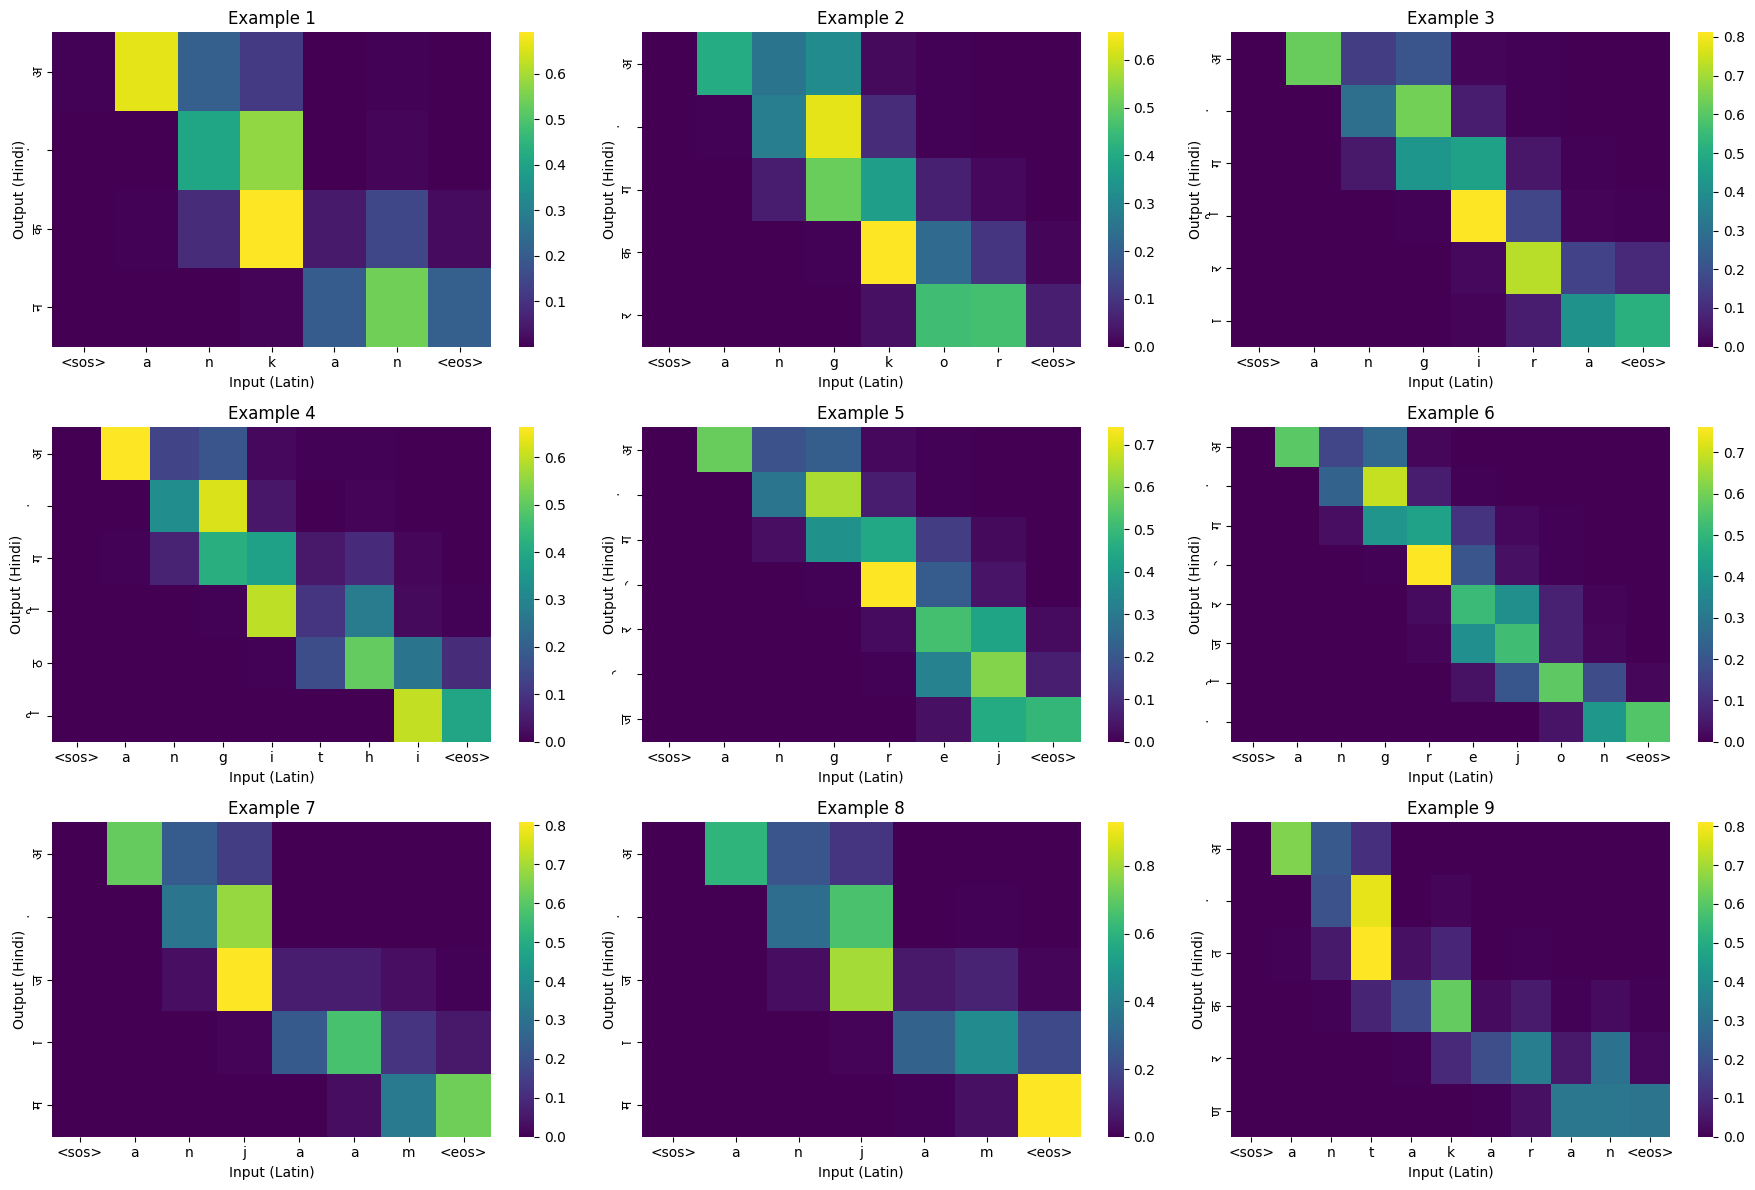

/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)


In [ ]:
attention_data = evaluate_with_attention(test_dataloader, encoder, decoder, target_idx2char, target_char2idx, input_idx2char, device, max_len=30)
plot_attention_heatmaps(attention_data)
